In [89]:
from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [90]:
#read datset
dataset = pd.read_csv('D:\\processedData.csv', index_col=[0,1,2])

#drop columns
dataset.drop('Week Start Date', axis=1, inplace=True)

#rename columns
dataset = dataset.rename(columns={"Total Case": "total_cases",
                    "Max Temperature": "max_temperature",
                    "Min Temperature": "min_temperature",
                    "Average Temperature": "avg_temperature",
                    "Average Precipitation": "avg_precipitation",
                    "Wind Speed": "wind_speed"})

#convert to date
#dataset['Week Start Date'] = pd.to_datetime(dataset['Week Start Date']) 
#dataset['Week Start Date'] 

#dataset.drop('wind_speed', axis=1, inplace=True)
#dataset.drop('Wind Direction', axis=1, inplace=True)
#dataset.drop('Visibility', axis=1, inplace=True)
#dataset.drop('Cloud Cover', axis=1, inplace=True)

In [91]:
dataset.tail(100)

total_cases  max_temperature  min_temperature  avg_temperature  \
   Year Week                                                                   
4  2016 5            1616             35.0             25.8        28.028571   
5  2016 6            1333             33.9             26.0        28.085714   
6  2016 7            1496             34.9             26.0        28.528571   
7  2016 8            1575             35.0             25.0        28.200000   
8  2016 9            1450             35.9             26.0        29.057143   
...                   ...              ...              ...              ...   
47 2017 48            418             33.8             25.0        26.728571   
48 2017 49            466             34.0             27.0        28.685714   
49 2017 50            459             34.0             25.8        27.800000   
50 2017 51            541             33.7             25.0        27.428571   
51 2017 52            553             33.9             25.0        27.371429   

              avg_precipitation  wind_speed  Wind Direction  Visibility  \
   Year Week                                                              
4  2016 5              7.975714   15.114286      184.431429    8.171429   
5  2016 6              0.570000   13.685714      178.642857    8.857143   
6  2016 7              3.247143   18.800000      169.937143    9.414286   
7  2016 8              3.545714   14.728571      165.815714    8.271429   
8  2016 9              2.381429   13.442857      144.068571    9.885714   
...                         ...         ...             ...         ...   
47 2017 48            11.582857   15.071429      202.425714    9.085714   
48 2017 49             4.977143   15.357143      139.067143    9.800000   
49 2017 50             6.142857   16.428571      141.468571    8.771429   
50 2017 51             1.700000   14.471429      136.588571    9.385714   
51 2017 52             5.145714   14.814286      166.502857    9.114286   

              Cloud Cover  Average Relative Humidity  
   Year Week                                          
4  2016 5       89.357143                  80.470000  
5  2016 6       89.671429                  77.670000  
6  2016 7       88.842857                  72.694286  
7  2016 8       89.085714                  74.670000  
8  2016 9       89.014286                  70.081429  
...                   ...                        ...  
47 2017 48      59.014286                  86.090000  
48 2017 49      59.771429                  78.900000  
49 2017 50      58.700000                  81.710000  
50 2017 51      58.928571                  78.465714  
51 2017 52      58.714286                  80.297143  

[100 rows x 10 columns]

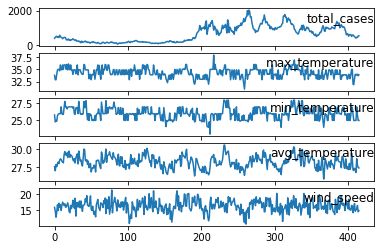

In [92]:
#plot all the column
values = dataset.values

#specify which columns to plot
groups = [0, 1, 2, 3, 5]
i = 1

#plot each columns
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [93]:
#prepare data for LSTM
#convert seriest to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    #input sequence (t-n, ...t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    #forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        
    #combine all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [94]:
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])

#ensure all data is float
values = values.astype('float32')

#normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

#drop columns that we don't wanna predict
reframed.drop(reframed.columns[[11, 12, 13, 14, 15, 16, 17, 18, 19]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[7, 8, 9, 10, 11]], axis=1, inplace=True)

reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.168110   0.405797       0.56   0.365781   0.763636   0.492578   
2   0.202751   0.275362       0.36   0.244837   0.472727   0.377868   
3   0.220071   0.275362       0.40   0.427729   0.046753   0.201080   
4   0.231788   0.434783       0.38   0.365781   0.514286   0.348178   
5   0.199185   0.565217       0.54   0.451327   0.522078   0.565452   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1   0.315833   0.750799   0.952810    0.629491  0.202751  
2   0.225049   0.758786   0.946804    0.561862  0.220071  
3   0.354993   0.774760   0.937366    0.539037  0.231788  
4   0.381064   0.741214   0.936937    0.622909  0.199185  
5   0.361454   0.720447   0.942943    0.597790  0.205807

In [95]:
#fit the model 

values = reframed.values
n_train_hours = 332
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

#split into input and outputs 
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#reshape the input into 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(332, 1, 10) (332,) (83, 1, 10) (83,)


Epoch 1/50
5/5 - 3s - loss: 0.2231 - val_loss: 0.3186
Epoch 2/50
5/5 - 0s - loss: 0.2112 - val_loss: 0.2922
Epoch 3/50
5/5 - 0s - loss: 0.2058 - val_loss: 0.2708
Epoch 4/50
5/5 - 0s - loss: 0.2038 - val_loss: 0.2554
Epoch 5/50
5/5 - 0s - loss: 0.2023 - val_loss: 0.2441
Epoch 6/50
5/5 - 0s - loss: 0.2006 - val_loss: 0.2353
Epoch 7/50
5/5 - 0s - loss: 0.1986 - val_loss: 0.2285
Epoch 8/50
5/5 - 0s - loss: 0.1965 - val_loss: 0.2231
Epoch 9/50
5/5 - 0s - loss: 0.1942 - val_loss: 0.2189
Epoch 10/50
5/5 - 0s - loss: 0.1916 - val_loss: 0.2155
Epoch 11/50
5/5 - 0s - loss: 0.1889 - val_loss: 0.2125
Epoch 12/50
5/5 - 0s - loss: 0.1860 - val_loss: 0.2098
Epoch 13/50
5/5 - 0s - loss: 0.1829 - val_loss: 0.2070
Epoch 14/50
5/5 - 0s - loss: 0.1796 - val_loss: 0.2041
Epoch 15/50
5/5 - 0s - loss: 0.1763 - val_loss: 0.2007
Epoch 16/50
5/5 - 0s - loss: 0.1728 - val_loss: 0.1970
Epoch 17/50
5/5 - 0s - loss: 0.1693 - val_loss: 0.1930
Epoch 18/50
5/5 - 0s - loss: 0.1656 - val_loss: 0.1888
Epoch 19/50
5/5 - 0

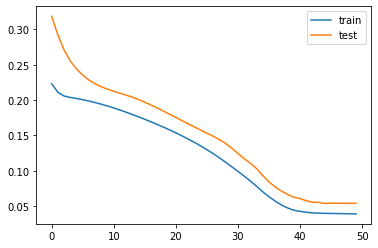

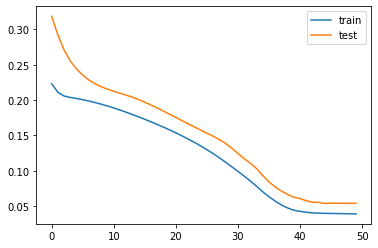

In [96]:
#fit the model

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

#fit the network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show(0)

In [97]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

#invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

#calculate the RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 131.457


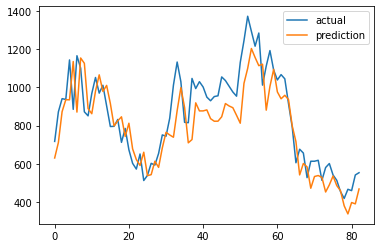

In [98]:
plt.plot(inv_y, label='actual')
plt.plot(inv_yhat, label='prediction')
plt.legend()
plt.show()